In [17]:
import csv
import matplotlib.pyplot as plt
import nltk
import pandas
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn import metrics

pandas.set_option('display.max_rows', 1000)

# loading the dataset
dataset = pandas.read_csv("labeled01.csv",sep=',',usecols=['tweet','label'])

print(type(dataset))
print(f"Number of tweets: {len(dataset)}")
display(dataset)

<class 'pandas.core.frame.DataFrame'>
Number of tweets: 666


,tweet,label
0,Vaccini: il successo della Brexit premetterà a...,1
1,Aifa autorizza il vaccino AstraZeneca ma ne ra...,1
2,vaccini Mentre l'EU cerca (tra l'altro senza s...,0
3,Si andrebbe presumibilmente ben oltre l'anno. ...,2
4,"Oggi 30 gennaio , ho ricevuto la seconda dose ...",1
5,"In realtà, soprattutto nel caso di confronto c...",2
6,Quale sarebbe il vantaggio del nuovo vaccino t...,0
7,firewall76 nicolatosti1 ScaltritiLab rominafuo...,0
8,vaccino vaccini vaccinoCovid mammamia bambini ...,0
9,antonellaviol17 Dipende. Cosa succederà se avr...,2


In [18]:
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

italian_stemmer = SnowballStemmer('italian')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(dataset.tweet, dataset.label, test_size=0.4)

In [28]:
#counting the word occurrences,it includes tokenization and stopword filtering, check parameters
count_vect = StemmedCountVectorizer(min_df=2, analyzer="word",ngram_range=(1,2), stop_words = set(stopwords.words('italian')))
#count_vect = CountVectorizer(stop_words=stopwords,analyzer=stemming,min_df=2)

X_train_counts = count_vect.fit_transform(X_train)
#extracted tokens
#print(count_vect.get_feature_names())
  
# Text rapresentation supervised stage on training set, include calculation of TFs (frequencies)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)  
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# TF-IDF extraction on test set, tokenization and word counting,feature extraction
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [29]:
def evaluate_classifier(clf):
    clf.fit(X_train_tfidf, y_train)
    #Evaluation on test set
    predicted = clf.predict(X_test_tfidf)#prediction
    #Extracting statistics and metrics
    accuracy=np.mean(predicted == y_test)#accuracy extreaction
    print('accuracy : ' + str(accuracy))

    f_score = f1_score(y_test, predicted, average='macro')
    print('f_score : ' + str(f_score) + '\n')

    disp = plot_confusion_matrix(clf, X_test_tfidf, y_test, cmap=plt.cm.Blues, normalize='true')
    disp.ax_.set_title('Confusion Matrix')
    plt.show()

Multinomial NB:
accuracy : 0.5056179775280899
f_score : 0.48282852239686774



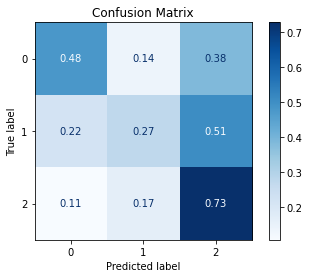

Decision Tree:
accuracy : 0.43820224719101125
f_score : 0.44004361651420476



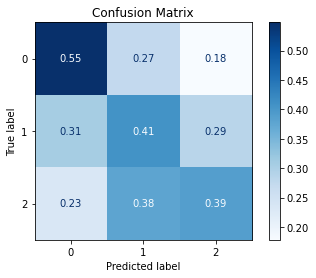

SVM:
accuracy : 0.4794007490636704
f_score : 0.46693683635011185



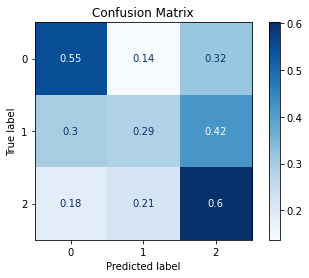

k-NN (k = 5) :
accuracy : 0.4307116104868914
f_score : 0.42693805975032467



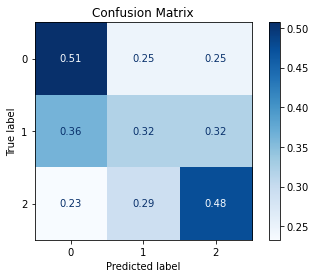

Adaboost:
accuracy : 0.37453183520599254
f_score : 0.37418778427550353



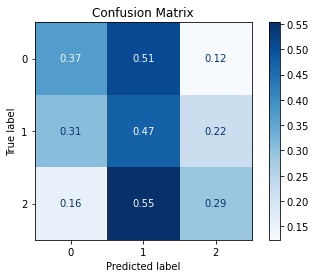

Random Forest:
accuracy : 0.44569288389513106
f_score : 0.4264807412955561



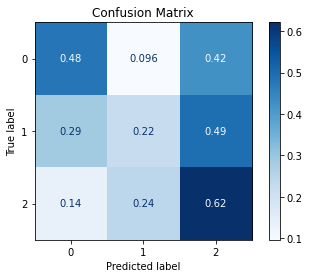

In [30]:
#Training the classifiers

# --------------- BAYESS ---------------
clf1 = MultinomialNB()
print('Multinomial NB:')
evaluate_classifier(clf1)

# --------------- DECISION TREE ---------------
clf2 = tree.DecisionTreeClassifier()
print('Decision Tree:')
evaluate_classifier(clf2)

# --------------- SVC ---------------
clf3 = svm.LinearSVC()
print('SVM:')
evaluate_classifier(clf3)

# --------------- K-NN ---------------
k_neighbor = 5
clf4 = KNeighborsClassifier(k_neighbor)
print('k-NN (k = ' + str(k_neighbor) + ') :')
evaluate_classifier(clf4)

# --------------- ADABOOST ---------------
clf5 = AdaBoostClassifier()
print('Adaboost:')
evaluate_classifier(clf5)

# --------------- RANDOM FOREST ---------------
clf6 = RandomForestClassifier()
print('Random Forest:')
evaluate_classifier(clf6)